[25917 22594 14528]
[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] [-1. -1. -1. ..., -1. -1.  1.] [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]] [-1. -1.  1. ..., -1. -1.  1.]
 loss test nag: 3257.0
 loss test nag: 1678.89287864
 loss test nag: 1357.2708204
 loss test nag: 1176.46786037
 loss test nag: 1184.99199476
 loss test nag: 1145.88998936
 loss test nag: 1123.61616008
 loss test nag: 1200.39122657
 loss test nag: 1190.13672078
 loss test nag: 1156.80228721
 loss test nag: 1183.27759459
 loss test nag: 1148.06069438
 loss test nag: 1220.03802867
 loss test nag: 1092.61750947
 loss test nag: 1168.56166835
 loss test nag: 1147.20124174
 loss test nag: 1189.46422711
 loss test nag: 

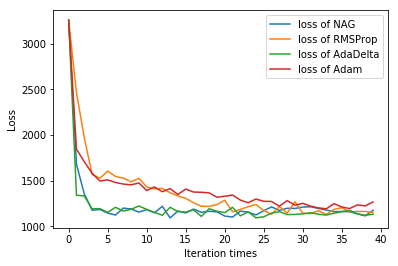

In [13]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math

eta = 0.0001 # Learning Rate
epsilon = 0.00001 #using in 4 optimalization methods to prevent the denominator become 0
iter =40# Iteration times
accuracy = 0.001 # If loss<accuracy , then stop iteration
lam = 0.1 #lambda used in Loss Function
mini_batch_percent = 0.2 #5% of dataset is used in loss function

m_train = 32561 # Amount of training data
m_test = 16281 # Amount of testing data
features=123 # Fearures of dataset

#Initialize arrays
w= [0]*features  #All zero initialization

#used to stastic and draw graph
iter_num = [0]*iter;
loss_train  = [0]*iter;
loss_test_nag  = [0]*iter;
loss_test_rmsprop  = [0]*iter;
loss_test_adadelta  = [0]*iter;
loss_test_adam  = [0]*iter;


#used in adadelta
sum_of_x_squared = 0
sum_of_grad_squared = 0
current = 0

#used in adam
mt = np.zeros(features)
vt =0 
beta1 = 0.9
beta2 = 0.999

#used in rmsProp
Eg2 = 0

#used in NAG
v = np.zeros(features)
miu = 0.9

#Use to get dataset from file
def get_data():
    data_train = load_svmlight_file("dataset\\a9a",n_features=features)
    X_train = data_train[0].toarray()
    y_train = data_train[1]
    data_test = load_svmlight_file("dataset\\a9a.t",n_features=features)
    X_test = data_test[0].toarray()
    y_test = data_test[1]
    return X_train, y_train, X_test, y_test

def  squared(vector):
    a = np.mat(vector)
    b = a*a.T
    return b[0][0]

def multiply(vector1,vector2):
    c= [0]*len(vector1)
    for i in range(0,len(vector1)):
        c[i] = vector1[i] * vector2[i]
    return c

#Loss function  
def loss(m,X,y):
    loss = 0.0
    for i in range (0,m):
        y_predict = 0
        for j in range(0,features):
            y_predict = y_predict + X[i][j] * w[j]
        if(y[i]*y_predict-1<0):
            loss += (1-y[i]*y_predict)
    for  j in range (0,features):
        loss = loss + 0.5 * lam * w[j] * w[j]
    return loss

#mini -batch loss function  
def SGD_loss(m,X,y):
    loss = 0.0
    sample_num =math.ceil( m * mini_batch_percent)
    target = np.random.permutation(m)[0:sample_num]
    for index in range (0,sample_num):
        i = target[index]
        y_predict = 0
        for j in range(0,features):
            y_predict = y_predict + X[i][j] * w[j]
        if(y[i]*y_predict-1<0):
            loss += (1-y[i]*y_predict)
    for  j in range (0,features):
        loss = loss + 0.5 * lam * w[j] * w[j]
    return loss


#Derivative the Loss function to get Gradient(G)
def derivative(m,X,y):
    y_predict = [0]*m 
    for i in range (0,m):
        y_predict[i] = 0
        for j in range(0,features):
            y_predict[i] = y_predict[i] + X[i][j] * w[j]
    
    grad = [0] * features
    for j in range(0,features):
        grad[j] = abs(lam*w[j])
        for i in range(0,m):
            if(y[i]*y_predict[i]-1<0):
                grad[j] = grad[j] - y[i] * X[i][j]
    return grad

#Derivative the Loss function to get Gradient(G)
def SGD_grad(m,X,y):
    
    sample_num =math.ceil( m * mini_batch_percent)
    target=random.sample(range(0,m),sample_num)
    
    y_predict = [0]*m
    for index in range (0,sample_num):
        i = target[index]
        y_predict[i] = 0
        for j in range(0,features):
            y_predict[i] = y_predict[i] + X[i][j] * w[j]
    
    grad = [0] * features
    for j in range(0,features):
        grad[j] = abs(lam*w[j])
        for index in range(0,sample_num):
            i = target[index]
            if(y[i]*y_predict[i]-1<0):
                grad[j] = grad[j] - y[i] * X[i][j]
    return grad

#Derivative the Loss function to get Gradient(G)
def derivative_random(m,X,y):
    i = random.randint(0,m-1)
    y_predict = 0
    for j in range(0,features):
        y_predict = y_predict + X[i][j] * w[j]
    
    grad = [0] * features
    for j in range(0,features):
        grad[j] = abs(lam*w[j])
        if(y[i]*y_predict-1<0):
             grad[j] = grad[j] - y[i] * X[i][j]
    
    return grad

def update(m,X,y,method):
    global w
    if (method=='nag'):
        grad = SGD_grad(m,X,y)
        w = w + NAG(grad)
    if (method=='rmsprop'):
        grad = SGD_grad(m,X,y)
        w = w + rmsProp(grad)
    if (method=='adadelta'):
        grad = SGD_grad(m,X,y)
        w = w + adadelta(grad)
    if (method=='adam'):
        grad = SGD_grad(m,X,y)
        w = w + adam(grad)
        
def adadelta(grad):
    global sum_of_grad_squared, sum_of_x_squared, current
    sum_of_grad_squared += squared(grad)
    grad2 = np.mat(grad)
    delta_x_mat =  -0.0001* grad2
    
    if(current==0):
        current+=1
        delta_x_mat = -0.0001*  grad2
    else:
        RMS_delta_x = math.sqrt(sum_of_x_squared/current)
        RMS_grad = math.sqrt(sum_of_grad_squared/(current+1))
        alpha = -1.0 * ( RMS_delta_x / RMS_grad)
        delta_x_mat = alpha * grad2
        current+=1
    sum_of_x_squared += squared(delta_x_mat.getA1())
    
    
    return delta_x_mat.getA1()

def adam(grad):
    global beta1,beta2,mt,vt,epsilon,current
    current+=1
    delta_x = [0]*features
    grad2 = np.mat(grad)
    mt = beta1 * mt + (1-beta1)*(grad2)
    vt = beta2 * vt + (1-beta2)*( (grad2 * grad2.T)[0,0])
    delta_x_mat = -eta *100 * (math.sqrt(1-beta2**current)/(1-beta1**current))*(mt/(math.sqrt(vt)+epsilon)) 
    
    return delta_x_mat.getA1()
    
def rmsProp(grad):
    global Eg2
    grad2 = np.mat(grad)
    gt2 = (grad2 * grad2.T)[0,0]
    Eg2 =  0.9 * Eg2 + 0.1 * gt2
    delta_x_mat =  -eta * 100 / (math.sqrt(Eg2+epsilon)) *(grad2)
    return delta_x_mat.getA1()
    
def NAG(grad):
    global v,eta,miu
    grad2 = np.mat(grad)
    v = miu * v  - eta * grad2
    return v.getA1()
    

'''
#Process Gradient descent to minimum the Loss
def update(m,X,y):
    # grad is the gradient G
    grad = derivative_random(m,X,y)
    delta_of_grad = delta_x(grad)
    for j in range(0,features):
         #" D = -G " is " - grad[j] " here
        w[j] = w[j] + delta_of_grad[j]


        
def delta_x(grad):
    return NAG(grad)

def adadelta(grad):
    global sum_of_grad_squared, sum_of_x_squared, current
    
    delta_x = [0]*features
    sum_of_grad_squared += squared(grad)
    
    if(current==0):
        current+=1
        delta_x =[ x * -0.0001 for x in grad ]
    else:
        RMS_delta_x = math.sqrt(sum_of_x_squared/current)
        RMS_grad = math.sqrt(sum_of_grad_squared/(current+1))
        eta = -1.0 * ( RMS_delta_x / RMS_grad)
        delta_x =[ x * eta for x in grad ]
        current+=1
    sum_of_x_squared += squared(delta_x)
   # print("delta_x:",delta_x)
    return delta_x

def adam(grad):
    global beta1,beta2,mt,vt,epsilon,current
    current+=1
    delta_x = [0]*features
    grad2 = np.mat(grad)
    mt = beta1 * mt + (1-beta1)*(grad2)
    vt = beta2 * vt + (1-beta2)*( (grad2 * grad2.T)[0,0])
    delta_x_mat = -eta * (math.sqrt(1-beta2**current)/(1-beta1**current))*(mt/(math.sqrt(vt)+epsilon)) 
    
    return delta_x_mat.getA1()
    
def rmsProp(grad):
    global Eg2
    grad2 = np.mat(grad)
    gt2 = (grad2 * grad2.T)[0,0]
    Eg2 =  0.9 * Eg2 + 0.1 * gt2
    delta_x_mat =  -eta / (math.sqrt(Eg2+epsilon)) *(grad2)
    return delta_x_mat.getA1()
    
def NAG(grad):
    global v,eta,miu
    grad2 = np.mat(grad)
    v = miu * v  - eta * grad2
    return v.getA1()
 '''   
    
#Train and validate 
def trainAndTest():
    
    global w
    
    
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_nag[i] =  SGD_loss(m_test,X_test,y_test)
        print(" loss test nag:",loss_test_nag[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'nag')
    
    w = [0]*features
  
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_rmsprop[i] =  SGD_loss(m_test,X_test,y_test)
        print(" loss test rmsProp:",loss_test_rmsprop[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'rmsprop')
    
    w = [0]*features    
   
    for i in range (0,iter):
        iter_num[i] = i;

        loss_test_adadelta[i] =  SGD_loss(m_test,X_test,y_test)
        print(" loss test adadelta:", loss_test_adadelta[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'adadelta')
    
    w = [0]*features
           
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_adam[i] =  SGD_loss(m_test,X_test,y_test)
        print(" loss test adam:",loss_test_adam[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'adam')
        
#The linear model
def predict(x):
    pre = 0.0
    for j in range (0,features):
        pre = pre + x[j] * w[j]
    if(pre>=0) :
        return 1
    else:
        return -1

def accRate(m,X,y):
    error = 0
    for i in range(0,m):
        if(predict(X[i])!=y[i]):
            error+=1
    print("total：",m," error:",error," acc rate:",1.0 - error/m )
    return 1.0 - error/m
    

#Test
print(np.random.permutation(m_train)[0:3])
    
#Main 
X_train, y_train, X_test,y_test = get_data()
print(X_train, y_train, X_test,y_test)
trainAndTest()


#Print the information and draw graphs
print("Features:",w)
fig, ax = plt.subplots()
ax.plot(iter_num, loss_test_nag,  label='loss of NAG')
ax.plot(iter_num, loss_test_rmsprop,  label='loss of RMSProp')
ax.plot(iter_num, loss_test_adadelta,  label='loss of AdaDelta')
ax.plot(iter_num, loss_test_adam,  label='loss of Adam')
plt.legend(bbox_to_anchor=[1, 1])  
ax.set_xlabel('Iteration times')
ax.set_ylabel('Loss')
plt.show()  
        
